# <center> Гуманитарная помощь. Кластеризация стран

<center> <img src=https://lms-cdn.skillfactory.ru/assets/courseware/v1/b5cc99e8741571ae77e8b1e6ec51523b/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/MATHML_md11_7_1.jpg align="right" width="250"/> </center>

Представьте, что вы работаете в международной гуманитарной организации, главная задача которой — борьба с бедностью и помощь людям из наименее развитых стран. Для выполнения своей миссии ваша организация периодически финансирует различные проекты, поддерживающие нуждающиеся регионы.

Вы собрали 100 миллионов долларов и должны принять решение, как распределить эти деньги — в какие страны их направить в первую очередь. Как выбрать, кто сильнее всего нуждается в финансовой поддержке?

Конечно, можно взять страны с самыми низкими доходами населения или с самой маленькой продолжительностью жизни. А может, лучше помочь странам, у которых самая высокая инфляция? По отдельным признакам выбирать достаточно сложно — нам хотелось бы выявить группы стран, в которых в целом ситуация вызывает опасения по совокупности значений всех признаков.

Для решения этой задачи мы как раз и используем наши навыки в снижении размерности и кластеризации данных: попробуем выделить кластеры стран, схожих по своим характеристикам, и среди них выявить кластер особо нуждающихся.

In [1]:
# Подгрузим инструментарий
# Для анализа данных и операций с числами
import pandas as pd 
import numpy as np

# Для кластеризации и расчета метрик
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Для графики и отображения
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')

# Подавление предупреждений
import warnings
warnings.filterwarnings('ignore')


c:\Python311\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Загрузка и обработка данных

Данные содержат следующие признаки:

|feature|description|feature|description|
|-|-|-|-|
|`country`|название страны|`Income`|средний доход на душу населения|
|`child_mort`|показатель смертности детей до 5 лет|`Inflation`|годовой показатель инфляции|
|`exports`|показатель экспорта на душу населения|`life_expec`|средняя продолжительность жизни|
|`health`|показатель затрат на здравоохранение на душу населения|`total_fer`|суммарный коэффициент рождаемости|
|`imports`|показатель импорта на душу населения|`gdpp`|значение ВВП на душу населения|

In [2]:
country_df = pd.read_csv('data/Country-data.zip')
print('Число представленных в наших данных стран:', country_df.shape[0])
country_df.head()

Число представленных в наших данных стран: 167


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Посмотрим на минимальные значения показателя средней продолжительности жизни среди представленных стран.

In [3]:
country_df[['country', 'life_expec']].sort_values(by='life_expec')[:5]

,country,life_expec
66,Haiti,32.1
87,Lesotho,46.5
31,Central African Republic,47.5
166,Zambia,52.0
94,Malawi,53.1


Специфика нашей задачи предполагает детальный анализ стран. Однако мы можем заметно ускорить процесс предоставления гуманитарной помощи, если вместо ручного анализа всех стран по каждому признаку разделим их на схожие кластеры с помощью специального алгоритма, а уже затем приступим к анализу самих кластеров.

### Стандартизация данных

Чтобы получить более качественные результаты, необходимо стандартизировать данные.

In [4]:
X = country_df.drop('country',axis =1)  
y = country_df['country']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Понижение размерности

Нет смысла использовать сильно связанные друг с другом признаки, так как их можно преобразовать в один и таким образом уменьшить общее количество признаков. Выясним, есть ли в данных такие признаки.

Число столбцов: 9
Ранг матрицы:   9
Определитель:   0.0007368108802301368


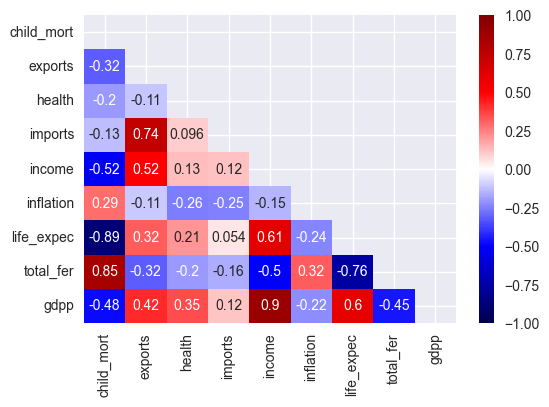

In [5]:
# Матрица корреляций
corr_mtrx = pd.DataFrame(data=X_scaled, columns=X.columns).corr()
# Выведем тепловую карту на основе матрицы корреляций
matrix = np.triu(corr_mtrx) # Треугольная маска
fig, axes = plt.subplots(figsize=(6, 4))
# Тепловая карта
sns.heatmap(
    corr_mtrx, vmin=-1, vmax=1, cmap='seismic',
    annot=True, mask=matrix, ax=axes
);
# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Как видим по значению определителя матрицы, присутствует мультиколлинеарность. Нам нужно понизить размерность данных — возьмём для этого метод главных компонент (PCA) как самый простой и популярный.

Найдите минимальное число компонент, которые суммарно могут объяснить 99 % разброса данных.

In [6]:
# Определяем метод таким образом, чтобы отобранные им
# компоненты объясняли не менее 95 % разброса данных
pca = PCA(n_components=0.95, random_state=42).fit(X_scaled)
# Обучаем алгоритм на наших данных
print(f'Число компонент: {len(pca.components_)}')

Число компонент: 6


Отлично! Можно отметить, что для того, чтобы объяснить бόльшую часть дисперсии, совершенно не требуется брать все признаки.

Посмотрим, какую долю дисперсии объясняют вычисленные компоненты.

In [7]:
np.round(pca.explained_variance_ratio_, 2)

array([0.46, 0.17, 0.13, 0.11, 0.07, 0.02])

При создании компонент с помощью PCA они должны получиться независимыми, то есть мы не должны теперь наблюдать высоких коэффициентов корреляции.

Число столбцов:

 6
Ранг матрицы:   6
Определитель:   1.0


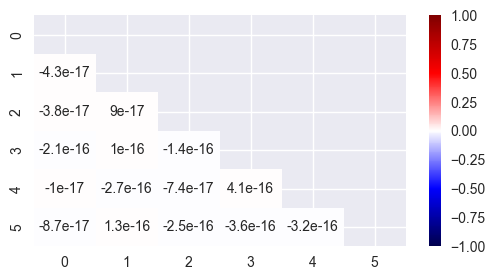

In [8]:
X_pca = pca.fit_transform(X_scaled)
# Матрица корреляций
corr_mtrx = np.corrcoef(X_pca.transpose())
# Выведем тепловую карту на основе матрицы корреляций
matrix = np.triu(corr_mtrx) # Треугольная маска
fig, axes = plt.subplots(figsize=(6, 3))
# Тепловая карта
sns.heatmap(
    corr_mtrx, vmin=-1, vmax=1, cmap='seismic',
    annot=True, mask=matrix, ax=axes
);
# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Как видим, даже самый большой коэффициент корреляции практически неотличим от нуля — это значит, что мы всё сделали правильно, и теперь у нас есть шесть независимых признаков, объясняющих до 95 % дисперсии.

## Кластеризация

Теперь, когда мы уменьшили размерность данных, можно переходить к кластеризации. Подберем оптимальное количество кластеров с помощью коэффициента силуэта, индекса Калински-Харабаса и индекса Дэвиса-Болдина, перебирая возможные значения от 2 до 10 включительно.

In [9]:
silhouette, calinski_harabasz, davies_bouldin = dict(), dict(), dict()
# Проходимся циклом по всем нужным нам значениям количества кластеров
for n in range(2, 10):
	# Обучаем модель k-means с текущим количеством кластеров
    km = KMeans(n_clusters=n, n_init=10, random_state=1).fit(X_pca)
	# Выводим результат для коэффициента силуэта
    silhouette[n] = silhouette_score(X_pca, km.labels_, metric='euclidean')
    calinski_harabasz[n] = calinski_harabasz_score(X_pca, km.labels_)
    davies_bouldin[n] = davies_bouldin_score(X_pca, km.labels_)

n_kl_silh = sorted(silhouette, key=lambda x: silhouette[x], reverse=True)[0]
print(f'Число кластеров с оптимальным коэффициентом силуэта: {n_kl_silh}, {round(silhouette[n_kl_silh], 2)}')
n_kl_ch = sorted(calinski_harabasz, key=lambda x: calinski_harabasz[x], reverse=True)[0]
print(f'Число кластеров с оптимальным индексом Калински-Харабаса: {n_kl_ch}, {round(calinski_harabasz[n_kl_ch], 2)}')
n_kl_db = sorted(davies_bouldin, key=lambda x: davies_bouldin[x])[0]
print(f'Число кластеров с оптимальным индексом Дэвиса-Болдина: {n_kl_db}, {round(davies_bouldin[n_kl_db], 2)}')

Число кластеров с оптимальным коэффициентом силуэта: 5, 0.32
Число кластеров с оптимальным индексом Калински-Харабаса: 2, 74.22
Число кластеров с оптимальным индексом Дэвиса-Болдина: 5, 0.83


Теперь, когда оптимальное количество кластеров выбрано, реализуйте алгоритм k-means с этим параметром.

Выясним, в какой кластер попали страны, у которых самый высокий показатель детской смертности и самый низкий ВВП на душу населения.

Кластеры: [0, 1, 2, 3, 4]
Составы:  [85, 31, 47, 3, 1]


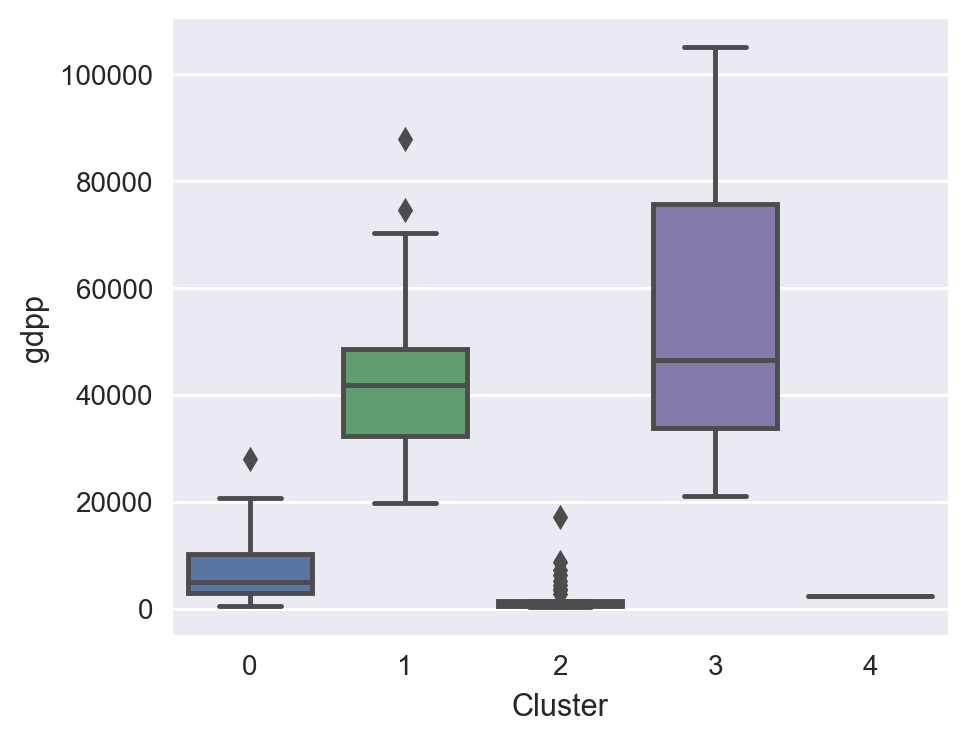

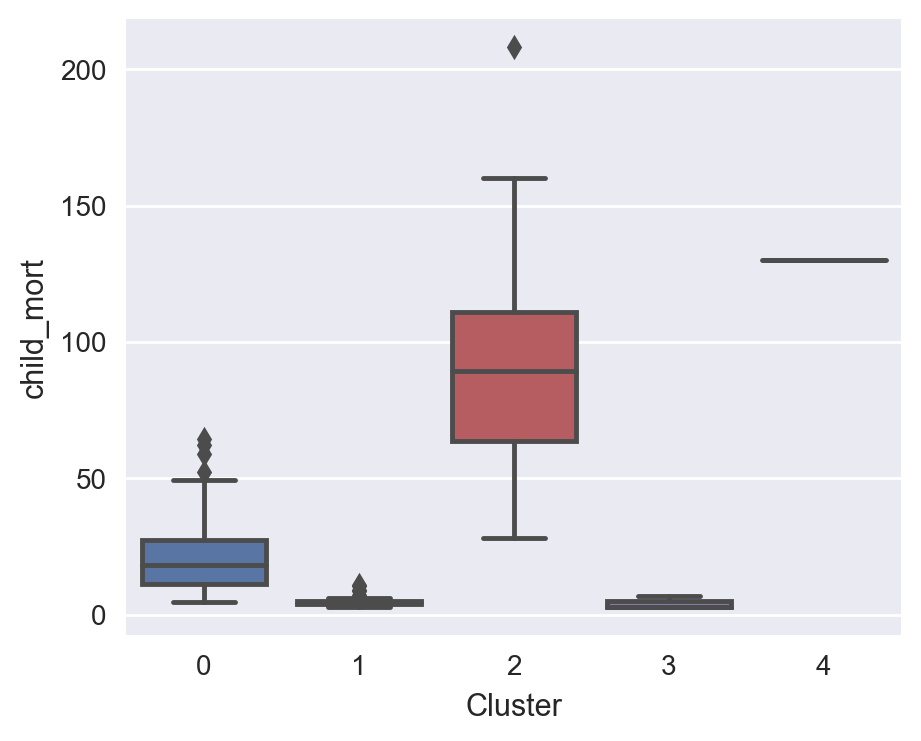

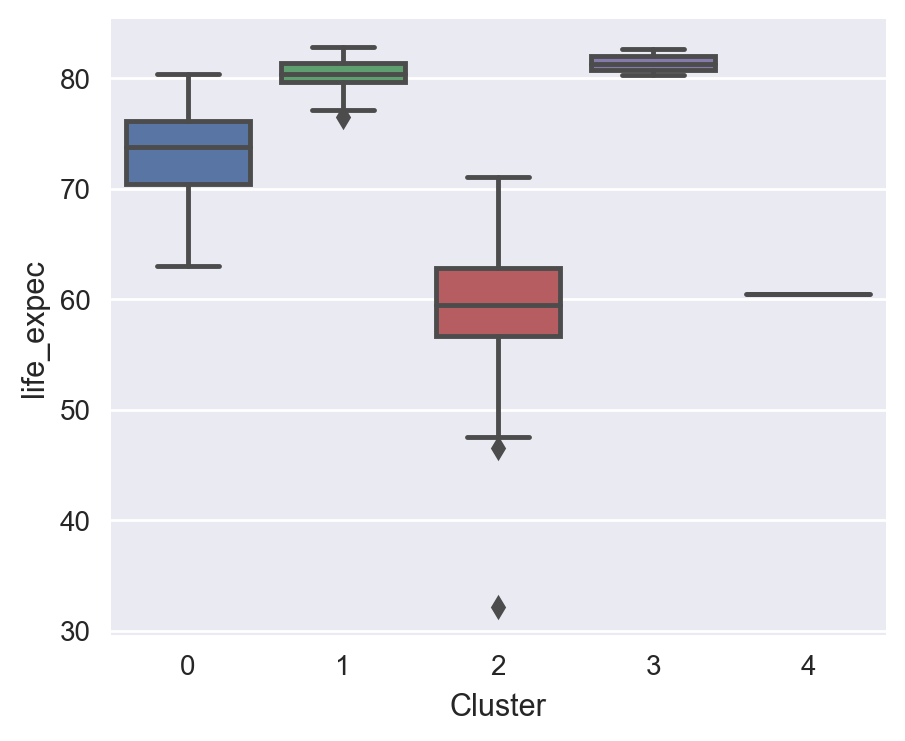

In [11]:
kmeans = KMeans(
    n_clusters=5,
    n_init=10,
    random_state=1
)
kmeans.fit(X_pca)
country_df['Cluster'] = kmeans.labels_
klss, cmpss = np.unique(kmeans.labels_, return_counts=True)
print(f'Кластеры: {list(klss)}')
print(f'Составы:  {list(cmpss)}')
plt.figure(figsize=(5,4),dpi=200)
sns.boxplot(x='Cluster', y='gdpp', data=country_df)
plt.figure(figsize=(5,4),dpi=200)
sns.boxplot(x='Cluster', y='child_mort', data=country_df)
plt.figure(figsize=(5,4),dpi=200)
sns.boxplot(x='Cluster', y='life_expec', data=country_df);

Судя по всему, страны из кластеров 2 и 4 являются наименее благополучными. Четвертый кластер вовсе представлен одной страной, т.е. является аномальным для других групп. Во втором кластере нам еще предстоит выяснить самую неблагополучную.

In [13]:
mask1 = country_df['Cluster'] == 2
mask2 = country_df['Cluster'] == 4
K_Means_countries = country_df[mask1 | mask2]
K_Means_countries.sort_values(by='child_mort', ascending=0)[:6]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
66,Haiti,208.0,15.3,6.91,64.7,1500,5.45,32.1,3.33,662,2
132,Sierra Leone,160.0,16.8,13.10,34.5,1220,17.20,55.0,5.20,399,2
32,Chad,150.0,36.8,4.53,43.5,1930,6.39,56.5,6.59,897,2
31,Central African Republic,149.0,11.8,3.98,26.5,888,2.01,47.5,5.21,446,2
97,Mali,137.0,22.8,4.98,35.1,1870,4.37,59.5,6.55,708,2
113,Nigeria,130.0,25.3,5.07,17.4,5150,104.00,60.5,5.84,2330,4


Так мы получили failed states таблицу и, кажется, смогли установить наиболее вероятных претендентов на гуманитарную помощь.